# Оценка потенциального экономического эффекта от внедрения полученного решения

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.evaluate import lift_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('orange_small_churn_train_data.csv')
df_test = pd.read_csv('orange_small_churn_test_data.csv')
target = 'labels'
IDcol = 'ID'

In [3]:
cat_columns = df.select_dtypes(include='object').columns
df[cat_columns] = df[cat_columns].astype(np.str)
df_test[cat_columns] = df_test[cat_columns].astype(np.str)
df.loc[df[target]==-1, target] = 0

In [4]:
# вспомогательная функция для кодирования всех категориальных признаков
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        res = X.copy()
        if self.columns is not None:
            for col in self.columns:
                res[col] = LabelEncoder().fit_transform(res[col])
        else:
            for colname, col in res.iteritems():
                res[colname] = LabelEncoder().fit_transform(col)
        return res

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [5]:
# закодируем категориальные признакии с помощью Label Encoder
encoder = MultiColumnLabelEncoder(columns=cat_columns)
df = encoder.fit_transform(df)
df_test = encoder.transform(df_test)

In [6]:
predictors = [x for x in df.columns if x not in [target, IDcol, 'Var198', 'Var220', 'Var133', 'Var140', 'Var32',
                                                 'Var39', 'Var15', 'Var8', 'Var48', 'Var141', 'Var20', 'Var31',
                                                 'Var42', 'Var52', 'Var55', 'Var79', 'Var167']]

In [7]:
train, test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target],
                                                stratify=df[target], test_size=0.2, random_state=42)
train[target] = y_train.values
test[target] = y_test.values

In [8]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, stratified=True,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False, seed=27)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain[predictors], dtrain[target], early_stopping_rounds=early_stopping_rounds, verbose=False,
            eval_metric='auc', eval_set=[(dtrain[predictors], dtrain[target]), (dtest[predictors], dtest[target])])
        
    test_predictions = alg.predict(dtest[predictors])
    test_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    print("Accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_predictions))
    print("PR-AUC: %.4g" % metrics.average_precision_score(dtest[target], test_predictions))
    print("ROC-AUC: %.4g" % metrics.roc_auc_score(dtest[target], test_predprob))
    print("F1: %.4g" % metrics.f1_score(dtest[target], test_predictions))
    print("Preсision: %.4g" % metrics.precision_score(dtest[target], test_predictions))
    print("Recall: %.4g" % metrics.recall_score(dtest[target], test_predictions))
    print("Lift : %.4g" % lift_score(dtest[target], test_predictions))

In [10]:
xgb8 = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=3, min_child_weight=3,
                     gamma=0, subsample=0.9, colsample_bytree=0.68, reg_alpha=0, scale_pos_weight=4,
                     sample_weight=train[target].apply(lambda x: 7 if x==1 else 1).values,
                     objective= 'binary:logistic', nthread=4, seed=27)
modelfit(xgb8, train, test, predictors)

96
Accuracy : 0.916
PR-AUC: 0.111
ROC-AUC: 0.7506
F1: 0.1962
Preсision: 0.3402
Recall: 0.1378
Lift : 4.575


## Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике.

Например, введите следующие параметры:
* сколько денег всреднем приносит один пользователь в месяц;
* сколько денег в среднем вы будете вкладывать в удержание одного пользователя;
* с какой вероятностью пользователь примет ваше предложение;
* сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.

In [ ]:
revenue_per_user = 500 # сколько денег всреднем приносит один пользователь в месяц
retention_cost = 50 # сколько денег в среднем вы будете вкладывать в удержание одного пользователя
retention_proba = 0.75 # с какой вероятностью пользователь примет ваше предложение
campaign_perc = 0.2 # сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании

## 1\. Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

In [226]:
pred_proba = pd.DataFrame(xgb8.predict_proba(test[predictors])[:,1], columns=['y_pred'])
pred_proba['y_true'] = y_test.values
pred_proba.sort_values('y_pred', ascending=False, inplace=True)
    
def economic_model(revenue_per_user=500, retention_cost=50, retention_proba=0.75, campaign_perc=0.2):
    campaign = pred_proba[:int(pred_proba.shape[0]*campaign_perc)]
    campaign_cost = campaign.apply(lambda x: retention_proba*revenue_per_user if x['y_true']==1 else 0, axis=1).sum()
    return campaign_cost-retention_cost*campaign.shape[0]

In [95]:
economic_model()

33625.0

## 2\. Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?

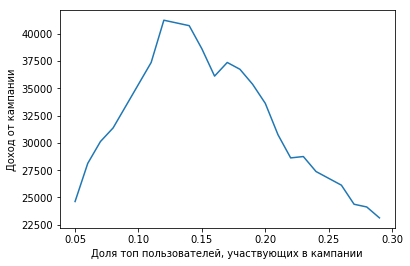

In [73]:
campaign_perc = [x/100.0 for x in range(5,30,1)]
campaign_rev = [economic_model(campaign_perc=x) for x in campaign_perc]
plt.xlabel('Доля топ пользователей, участвующих в кампании')
plt.ylabel('Экономический эффект от кампании')
plt.plot(campaign_perc, campaign_rev);

Чтобы экономический эффект был наибольшим, оптимально выбрать для проведения кампании по удержанию 12% топ пользователей, склонных к оттоку согласно модели.

## 3\. Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?

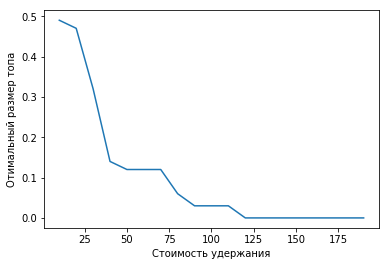

In [100]:
retention_cost = range(10,200,10)
best_campaign_perc = []

for rc in retention_cost:
    campaign_perc = [x/100.0 for x in range(1,50,1)]
    campaign_rev = [economic_model(retention_cost=rc, campaign_perc=x) for x in campaign_perc]
    best_campaign_perc.append(np.argmax(campaign_rev)/100.0+np.min(campaign_perc) if np.argmax(campaign_rev)>0 else 0)

plt.xlabel('Стоимость удержания')
plt.ylabel('Отимальный размер топа')
plt.plot([x for x in retention_cost], best_campaign_perc);

С увеличением стоимости удержания оптимальный размер топа уменьшается.
Капмания перестает быть оправданной при стоимости удержания более 25% от средней прибыли от пользователя в месяц.

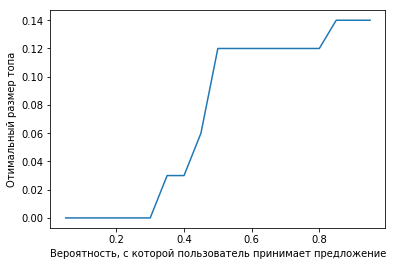

In [101]:
retention_proba = [x/100.0 for x in range(5,100,5)]
best_campaign_perc = []

for rp in retention_proba:
    campaign_perc = [x/100.0 for x in range(1,50,1)]
    campaign_rev = [economic_model(retention_proba=rp, campaign_perc=x) for x in campaign_perc]
    best_campaign_perc.append(np.argmax(campaign_rev)/100.0+np.min(campaign_perc) if np.argmax(campaign_rev)>0 else 0)

plt.xlabel('Вероятность, с которой пользователь принимает предложение')
plt.ylabel('Отимальный размер топа')
plt.plot(retention_proba, best_campaign_perc);

С увеличением вероятности, с которой пользователь принимает предложение, оптимальный размер топа увеличивается.
Капмания перестает быть оправданной при вероятности, с которой пользователь принимает предложение, меньшей 0.3.

## 4\. Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

Как видно на графиках выше, применение модели перестает быть оправданным, например, при следующих наборах значений:
* при стоимости удержания более 25% от средней прибыли от пользователя в месяц при средней прибыли на пользователя в месяц равной 500 и вероятности, с которой пользователь принимает предложение, равной 0.75
* при вероятности, с которой пользователь принимает предложение, меньшей 0.3 при средней прибыли на пользователя в месяц равной 500 и стоимости удержания равной 50

## 5\. Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

In [ ]:
pred_proba_base = pred_proba.copy()
campaign_rev_base = economic_model(campaign_perc=0.12)
roc_auc = metrics.roc_auc_score(pred_proba['y_true'], pred_proba['y_pred'])

In [228]:
pred_proba.set_value(pred_proba.iloc[pred_proba.y_true.values==0,1].iloc[:15].index, 'y_true', 1);
roc_auc_1 = metrics.roc_auc_score(pred_proba['y_true'], pred_proba['y_pred'])

In [229]:
roc_auc_1/roc_auc

1.0101197724172282

In [230]:
campaign_rev_1 = economic_model(campaign_perc=0.12)
campaign_rev_1/campaign_rev_base

1.1363636363636365

In [231]:
pred_proba.set_value(pred_proba.iloc[pred_proba.y_true.values==0,1].iloc[:32].index, 'y_true', 1);
roc_auc_3 = metrics.roc_auc_score(pred_proba['y_true'], pred_proba['y_pred'])
roc_auc_3/roc_auc

1.0299942935008601

In [232]:
campaign_rev_3 = economic_model(campaign_perc=0.12)
campaign_rev_3/campaign_rev_base

1.4272727272727272

* При увеличении качества модели на 1% по метрике ROC-AUC экономический эффект от проведения кампании увеличится на 13.6%
* При увеличении качества модели на 3% по метрике ROC-AUC экономический эффект от проведения кампании увеличится на 42.7%

## 6\. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

Если рассмотреть крупную телеком-компанию, то вложение средств в улучшение качества модели скорее всего окажется экономически оправданным, т.к. увеличении качества модели даже на 3% экономический эффект от проведения кампании увеличивается практически в 1.5 раза. В крупной телеком-компании десятки тысяч пользователей склонны к оттоку, поэтому затраты на увеличение качества модели скорее всего окупятся экономическим эффектом от проведения кампании по удержанию.